In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
import tf_memory_limit
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or before importing pylab!
from keras import backend as K
import tensorflow as tf
import numpy as np
import ctcfgen
from convnet import Bias
from keras.models import load_model, Model
from keras.layers import Input, Activation
import viz_sequence
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import correlate2d
from scipy.special import logit

colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}

batch_size=32
input_window=256

model_path = '/home/kal/CTCF/mass_CTCF/output/strength/20171128_132105/20171128_132105_weights_3_247_45227.62.hdf5'
gen_path='/home/kal/data/ctcf_strengthgen.hdf5'

out_dir = os.path.dirname(model_path)

#layer_name = 'conv1d_3'
#filter_index = 2 # can be anything from 0 to 7 - this convolution had 8 filters

Using TensorFlow backend.


In [2]:
# load the model
model = load_model(model_path, custom_objects={'Bias':Bias})

# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)

# get the symbolic outputs of each "key" layer.
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict.keys())

dict_keys(['conv1d_3', 'spatial_dropout1d_2', 'final_conv', 'stackmax', 'bias', 'conv1d_2', 'lambda_1', 'input_1', 'wide_scan', 'conv1d_4', 'spatial_dropout1d_4', 'conv1d_1', 'spatial_dropout1d_1', 'spatial_dropout1d_3'])


In [3]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [4]:
def rejection(seq_a, seq_b):
    """utiliy function to compute rejection of a from b"""
    out = list()
    for a, b in zip(seq_a, seq_b):
        if np.linalg.norm(b) == 0:
            out.append(a)
        else:
            out.append(a - ((np.dot(a, b) / (np.linalg.norm(b)**2)) * b))
    return np.asarray(out)

In [5]:
def softmax(batch):
    norm_batch = []
    for seq in batch:
        norm_batch.append([_softmax(base) for base in seq])
    return np.asarray(norm_batch)
    
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [6]:
def seq_from_distribution(distribution):
    seq = []
    one_hots = ctcfgen.encode(np.fromstring('acgt', np.uint8))
    for base in distribution:
        idx = np.random.choice(range(4), p=base)
        seq.append(one_hots[idx])
    return np.asarray(seq)

In [7]:
def build_iterate(model, filter_index, layer_name):
    
    # set a placeholder input
    encoded_seq = model.input

    # build a function that maximizes the activation of the nth filter of the layer considered
    if layer_name == 'final_output':
        activations = model.output

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(K.sum(activations), encoded_seq)[0]

    else:
        layer_output = layer_dict[layer_name].output

        activations = layer_output[:, :, filter_index]
        combined_activation = activations[:32] # we only generate forward sequences anyway

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(K.sum(K.max(combined_activation, axis=1)), encoded_seq)[0]

    # normalization trick: we normalize the gradient
    # grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([encoded_seq, K.learning_phase()], [activations, grads])
    
    return iterate

In [8]:
# find random sequences
def rand_seq_gen():
    while True:
        random = np.random.choice(np.fromstring('acgt', np.uint8), size=input_window)
        yield ctcfgen.encode(random).astype(np.float)
        
# we start from a random seq with some noise
r = rand_seq_gen()
rand_batch_gen = ctcfgen.filled_batch(r, batch_size=batch_size)

In [9]:
def good_pred_gen(r, model, cutoff=900):
    while True:
        seq = next(r)
        score = model.predict(np.asarray([seq]*32))[0][0]
        if score > cutoff:
             yield seq

In [10]:
def good_score_gen(r, cutoff=35):
    while True:
        seq = next(r)
        _, score = get_pwm([seq], get_score=True)
        if score > cutoff:
             yield seq

In [11]:
def good_batch_gen(batch_gen, op):
    #get a threshold value
    seqs = next(batch_gen)
    activations, grads = op([seqs, 0])
    max_value_1 = np.max(activations)
    seqs = next(batch_gen)
    activations, grads = op([seqs, 0])
    max_value_2 = np.max(activations)
    max_value = min(max_value_1, max_value_2)
    
    while True:
        good_batch = []
        while len(good_batch) < 32:
            seqs = next(batch_gen)
            activations, grads = op([seqs, 0])
            if layer_name == 'final_output':
                activations = np.append(activations, activations)
            importances = np.sum(grads, axis=-1)
            for seq_value, factivations, ractivations, importance_value in zip(seqs, activations[:32],activations[32:], importances):
                if np.max(factivations) >= max_value:
                    peak_index = np.argmax(importance_value)
                    good_batch.append(np.roll(seq_value, input_window//2-peak_index, axis=0))
                #if np.max(ractivations) >= max_value:
                    #peak_index = np.argmax(importance_value)
                    #reverse = ctcfgen.rc(np.asarray([seq_value]))[0]
                    #good_batch.append(np.roll(reverse, input_window//2-peak_index, axis=0))
        yield np.asarray(good_batch)[:32, :, :]

In [12]:
def dream(seq, iterate, n=20, orig=False, seq_center=0, verb=0):

    # get benchmark sequences
    orig_seq = seq
    
    # get a batch generator 
    def get_seq(start_seq):
        while True:
            yield seq_from_distribution(start_seq)
    batch_gen = ctcfgen.filled_batch(get_seq(seq), batch_size=32)
    
    # find an appropriate step size
    activations, grads = iterate([next(batch_gen), 0])
    max_grad = np.amax(grads)
    step = 8/(max_grad)
    
    if seq_center == 1:
        seq_center = np.argmax(np.amax(np.average(grads, axis=0), axis=1))
        print(seq_center)
    
    if verb > 1:
        print('initial sequence')
        if seq_center>0:
            viz_sequence.plot_icweights(seq[seq_center-40:seq_center+40])
        else:
            viz_sequence.plot_icweights(seq)
                
    if orig:
        #take an inital step
        seq = softmax([seq+np.average(grads, axis=0)*step])[0]
        print('First step')
        viz_sequence.plot_weights(seq)
        
    for i in range(n):
        # get some sequences
        batch_gen = ctcfgen.filled_batch(get_seq(seq), batch_size=32)
        input_seqs = next(batch_gen)
        # get the gradients 
        activations, grads = iterate([input_seqs, 0])
        
        #check changes are still made
        if (np.amax(grads) == .1):
            if verb != 0:
                print('sequence after '+ str(i+1) + ' iterations')
                viz_sequence.plot_weights(seq)
                print('Nothing is happening')
            break
            
        # update the sequence
        if orig:
            update = np.average(grads, axis=0)
            seq = np.log(seq) + update*step
        else:
            update = grads * input_seqs
            update = np.average(update, axis=0) * seq        
        
            seq = np.log(seq) + update*step - seq*.05
        seq = softmax([seq])[0] 
        
        #print some stuff
        if i % 10 == 0 and verb > 1:
            print('sequence after '+ str(i+1) + ' iterations')
            if seq_center>0:
                viz_sequence.plot_icweights(seq[seq_center-40:seq_center+40])
            else:
                viz_sequence.plot_icweights(seq)
            print('gradients')
            if seq_center>0:
                viz_sequence.plot_weights(update[seq_center-40:seq_center+40])
            else:
                viz_sequence.plot_weights(update)
            
        
    if verb > 0:
        print('sequence after '+ str(i+1) + ' iterations')
        if seq_center>0:
            viz_sequence.plot_icweights(seq[seq_center-40:seq_center+40])
        else:
            viz_sequence.plot_icweights(seq)
        
    return seq

In [13]:
def limited_dream(seq, iterate_op, limit_op, seq_center=0, n=20, neg=False, verb=0):
    # get benchmark pwm locations
    pwm, meme, position = get_pwm([seq], get_loc=True)

    # get benchmark sequences
    orig_seq = seq
    
    # get a batch generator 
    def get_seq(start_seq):
        while True:
            yield seq_from_distribution(start_seq)
    batch_gen = ctcfgen.filled_batch(get_seq(seq), batch_size=32)
    
    # find an appropriate step size
    activations, grads = iterate([next(batch_gen), 0])
    max_grad = np.amax(grads)
    step = 8/(max_grad)
    
    if seq_center == 1:
        seq_center = np.argmax(np.amax(np.average(grads, axis=0), axis=1))
        print(seq_center)
    
    if verb > 1:
        print('initial sequence')
        if seq_center>0:
            viz_sequence.plot_icweights(seq[seq_center-40:seq_center+40])
        else:
            viz_sequence.plot_icweights(seq)
                
        
    for i in range(n):
        # get some sequences
        batch_gen = ctcfgen.filled_batch(get_seq(seq), batch_size=32)
        input_seqs = next(batch_gen)
        # get the gradients 
        activations, grads = iterate([input_seqs, 0])

        
        #check changes are still made
        if (np.amax(grads) == .1):
            if verb != 0:
                print('sequence after '+ str(i+1) + ' iterations')
                viz_sequence.plot_weights(seq)
                print('Nothing is happening')
            break
          
        if neg:
            grads=-grads
            
        # update the sequence
        constrained = constrain(grads, input_seqs, get_pwm, meme, position)
        update = np.average(np.multiply(constrained, input_seqs), axis=0) 
        update = np.multiply(update, seq)
        
        seq = np.log(seq) + update*step
        seq = softmax([seq])[0] 
 
        #print some stuff
        if i % 10 == 0 and verb > 1:
            if seq_center>0:
                print('sequence after '+ str(i+1) + ' iterations')
                viz_sequence.plot_icweights(seq[seq_center-40:seq_center+40])
                print('gradients')
                viz_sequence.plot_weights(np.average(grads, axis=0)[seq_center-40:seq_center+40])
                print('constrain')
                viz_sequence.plot_weights(np.average(constrained, axis=0)[seq_center-40:seq_center+40])
                print('update')
                viz_sequence.plot_weights(update[seq_center-40:seq_center+40])
            else:
                print('sequence after '+ str(i+1) + ' iterations')
                viz_sequence.plot_icweights(seq)
                print('gradients')
                viz_sequence.plot_weights(np.average(grads, axis=0))
                print('constrain')
                viz_sequence.plot_weights(np.average(constrained, axis=0))
                print('update')
                viz_sequence.plot_weights(update)
            
        
    if verb > 0:
        print('sequence after '+ str(i+1) + ' iterations')
        if seq_center>0:
            viz_sequence.plot_icweights(seq[seq_center-40:seq_center+40])
        else:
            viz_sequence.plot_icweights(seq)
        
    return seq

In [14]:
def constrain(grads, input_seqs, limit_op, meme, position, verb=False):
    limits = limit_op(input_seqs, meme=meme, position=position)
    constrained = list()
    for grad, limit in zip(grads, limits):
        constrained.append(rejection(grad, limit))
    
    if verb:
        print('gradients')
        viz_sequence.plot_weights(grads[0])
        print('filters')
        viz_sequence.plot_weights(limits[0])
        print('constrained grads')
        viz_sequence.plot_weights(np.asarray(constrained)[0])
        
    return np.asarray(constrained)

MEME:


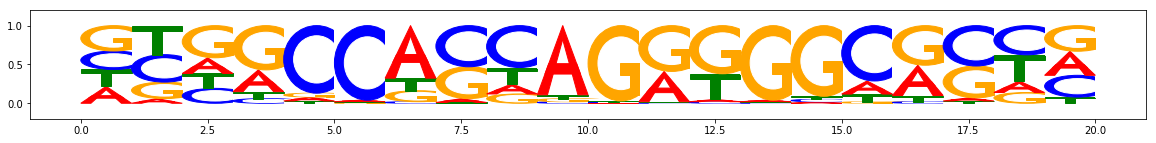

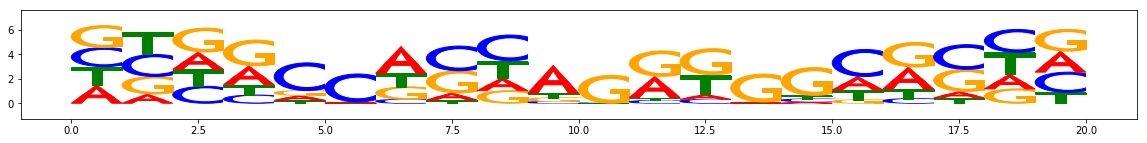

MEME:


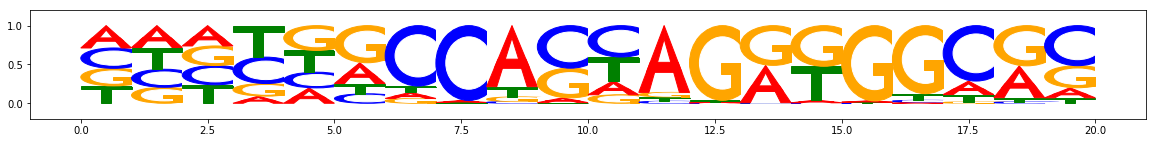

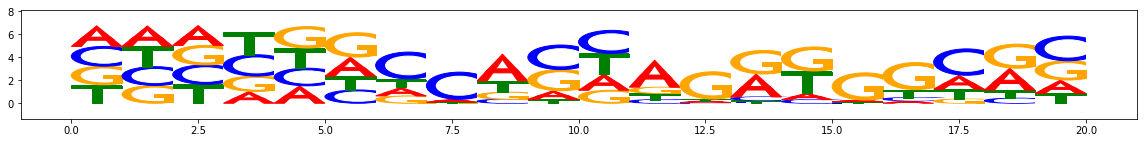

MEME:


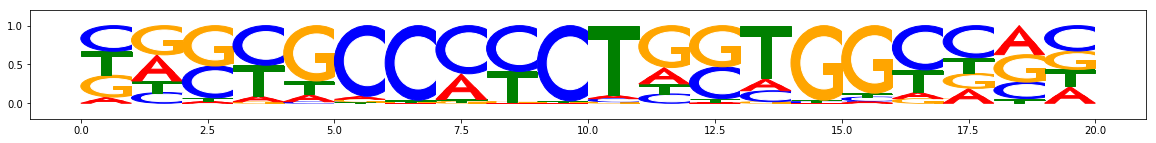

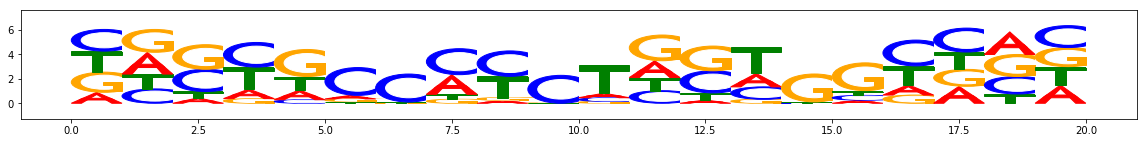

MEME:


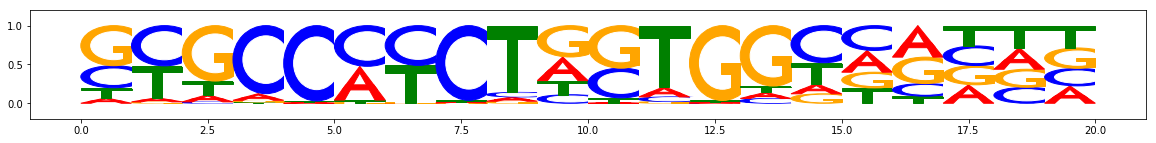

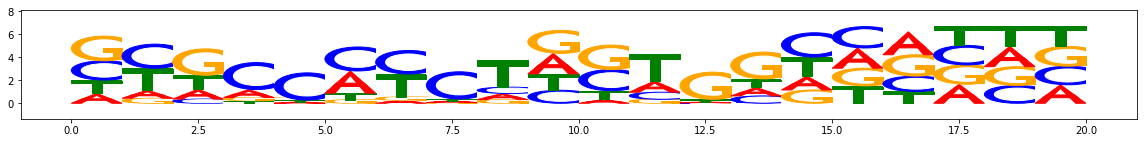

In [15]:
# process the memes
with open(meme_path, 'r') as infile:
    meme_length = -1
    CTCF_memes = list()
    for line in infile.readlines():
        if 'letter-probability matrix' in line:
            meme_length = int(line.split()[5])
            this_meme_lines = list()
        elif meme_length > 0:
            this_meme_lines.append([float(item.strip()) for item in line.split()])
            meme_length = meme_length - 1
        elif meme_length == 0:
            this_meme = np.asarray(this_meme_lines)
            CTCF_memes.append(this_meme)
            meme_length = -1
    if meme_length == 0:
        this_meme = np.asarray(this_meme_lines)
        CTCF_memes.append(this_meme)
        meme_length = -1
        
# add rcs of memes
rcs = list()
for meme in CTCF_memes:
    rcs.append(meme[::-1, ::-1])
CTCF_memes = CTCF_memes + rcs
    
    
psuedocount=0.1
# get the transformed memes
transformed_memes = list()
for meme in CTCF_memes:
    # add psuedo count
    print('MEME:')
    viz_sequence.plot_weights(meme)
    meme = meme + psuedocount 
    #viz_sequence.plot_weights(meme)
    # normalize
    #print('normalized:')
    norms = np.repeat(np.linalg.norm(meme, axis=1), 4).reshape((-1, 4))
    meme = meme/norms
    #viz_sequence.plot_weights(meme)
    # log transform
    #print('Log transformed')
    meme = np.log(meme)
    #viz_sequence.plot_weights(meme)
    # shift up
    #print('shift')
    min = np.amin(meme)
    meme = meme - min
    viz_sequence.plot_weights(meme)
    transformed_memes.append(meme)
    

def get_pwm(input_seqs, meme=None, position=None, meme_library=transformed_memes, get_score=False, get_loc=False):  
    # get position and meme if not specified
    if meme == None and position == None:
        get_loc = True
        for seq in input_seqs:
            best_score = -np.inf
            for test_meme in meme_library:
                correlations = correlate2d(seq, test_meme, mode='valid')
                if np.max(correlations) > best_score:
                    best_score = np.max(correlations)
                    best_location = np.argmax(correlations)
                    best_filter = test_meme
        position = best_location
        meme = best_filter
    else:
        get_loc = False
    
    # get the pwms
    output_scores = list()
    pwm = np.zeros(input_seqs[0].shape)
    pwm[position:position+meme.shape[0]] = meme
    for seq in input_seqs:
        output_scores.append(np.copy(pwm))    
    
    if get_score:
        corr = correlate2d(seq[position:position+meme.shape[0]], meme, mode='valid')
        return np.asarray(output_scores), np.max(corr)
            
    if get_loc:
        return np.asarray(output_scores), meme, position
    else:
        return np.asarray(output_scores)

In [16]:
def plot_activations(model, input_seqs, layer_name, all=True, viz=False, get_max=False, pre_max=None):
    seqs = model.input
    get_activations = K.function([seqs, K.learning_phase()], [layer_dict[layer_name].output, model.output])
    cmap = plt.get_cmap('plasma')
    def plot(ax, data, max_act):
        im = ax.imshow(data, interpolation='nearest',
                    cmap = cmap,
                    origin='lower',
                    aspect='auto', vmin=0, vmax = max_act)
        ax.axis('off')
        #fig.colorbar(im, ax=ax)
        
    activations, predictions = get_activations([input_seqs, 0])
    print(activations.shape)
    
    if all:                
        for fact, ract, seq, pred in zip(activations[:32], activations[32:], input_seqs, predictions):
            if pre_max==None:
                max_act=max(np.amax(fact), np.amax(ract))
            else:
                max_act = pre_max
            fig, (ax1, ax2) = plt.subplots(ncols=2)
            ax1.set(title='Forward (' + str(pred[0]) + ')')
            plot(ax1, np.transpose(fact), max_act)

            ax2.set(title='Reverse ('  + str(pred[0]) +')')
            plot(ax2, np.transpose(np.flip(ract, axis=0)), max_act)
            plt.tight_layout()
            plt.show()
            if viz:
                viz_sequence.plot_icweights(seq)
            if get_max:
                return max_act
    else:
        if pre_max==None:
            max_act=max(np.amax(activations[0]), np.amax(activations[32]))
        else:
            max_act=pre_max
        fig, (ax1, ax2) = plt.subplots(ncols=2)
        ax1.set(title='Forward (' + str(predictions[0][0]) + ') ' + layer_name)
        plot(ax1, np.transpose(activations[0]), max_act)

        ax2.set(title='Reverse ('  + str(predictions[0][0]) +') '+ layer_name)
        plot(ax2, np.transpose(np.flip(activations[32], axis=0)), max_act)
        plt.tight_layout()
        plt.show()  
        if viz:
            viz_sequence.plot_icweights(input_seqs[0])
        if get_max:
                return max_act

Layer: final_output , Filter: 0
PWM score 29.5329724452


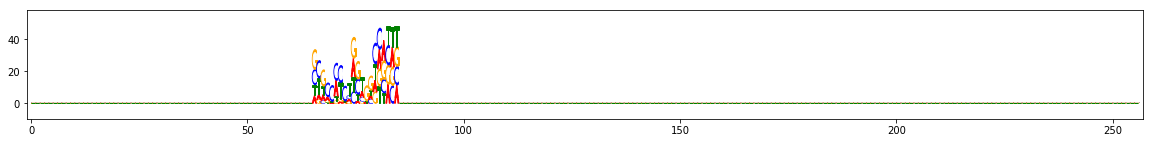

Prediction 0.0108025
Masked average prediciton difference


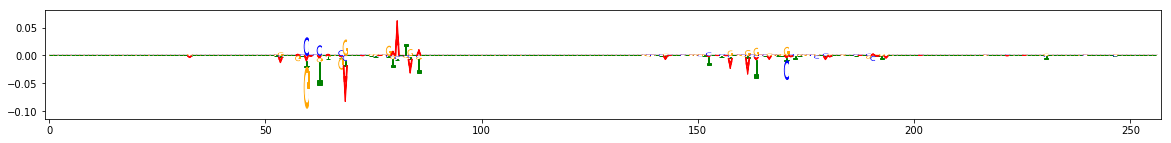

Prediction 0.0116916
Masked average prediciton difference


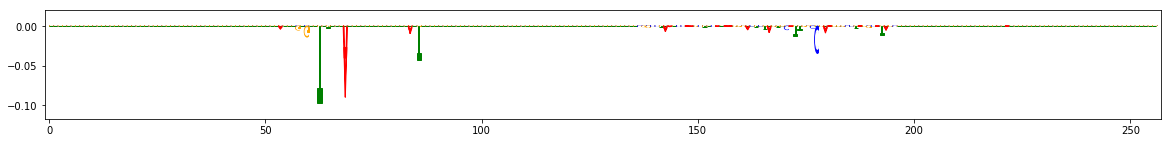

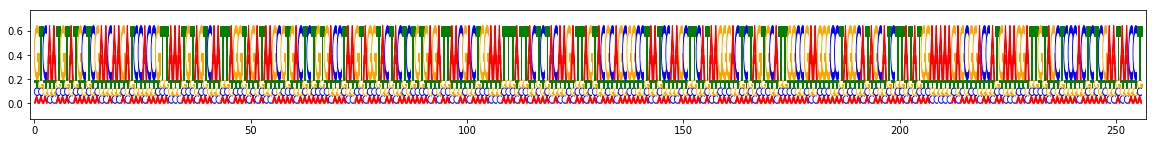

In [17]:
layer_name = 'final_output'
i=0

# get the specific filter within this layer we are looking at
print('Layer: ' + layer_name + ' , Filter: ' + str(i))

#build the iteration model
iterate = build_iterate(model, i, layer_name)
    
#find high scoring sequences
g = good_score_gen(rand_seq_gen(), cutoff=40)
p = good_pred_gen(rand_seq_gen(), model, cutoff=900)
rand = rand_seq_gen()

plain_seq = next(rand)
seq = plain_seq*.6 + .1
orig_seq = seq

pwm, orig_score = get_pwm([orig_seq], get_score=True)
print('PWM score ' + str(orig_score))
viz_sequence.plot_icweights(pwm[0])
ctcfgen.get_importance(orig_seq, model, viz=1)
ctcfgen.get_importance(plain_seq, model, viz=1)
_ = viz_sequence.plot_icweights(orig_seq)

In [18]:
seq = orig_seq

# dream the sequences
seq = dream(seq, iterate, seq_center=0, verb=0, n=20)

PWM score 29.2469328801


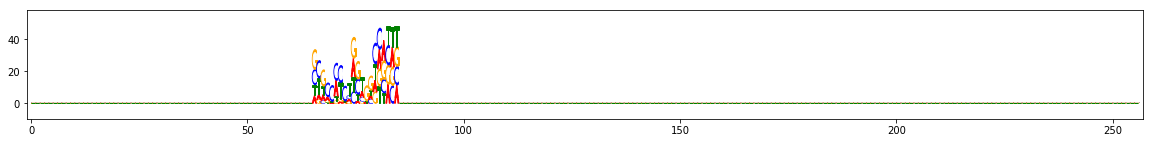

Prediction 0.648299
Masked average prediciton difference


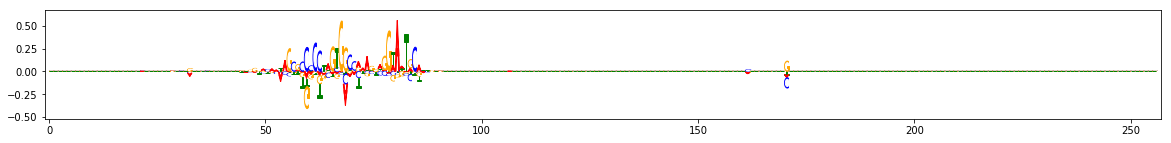

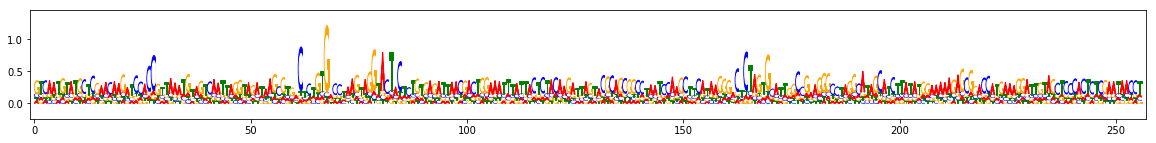

In [19]:
pwm, new_score = get_pwm([seq], get_score=True)
print('PWM score ' + str(new_score))
viz_sequence.plot_icweights(pwm[0])
ctcfgen.get_importance(seq, model, viz=1)
_ = viz_sequence.plot_icweights(seq)

In [20]:
# dream the sequences
seq = orig_seq
seq = limited_dream(seq, iterate, get_pwm, verb=0, n=3)

#change = seq - orig_seq 
#viz_sequence.plot_weights(change)

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:56: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


PWM score 29.5713998212


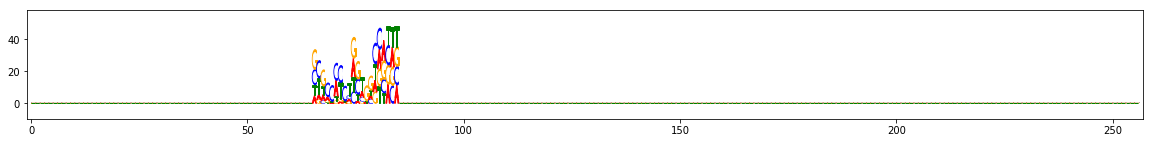

Prediction 0.0113955
Masked average prediciton difference


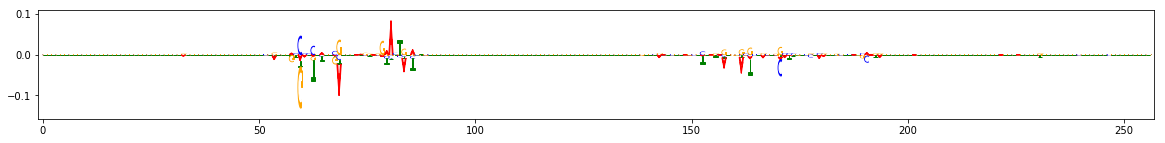

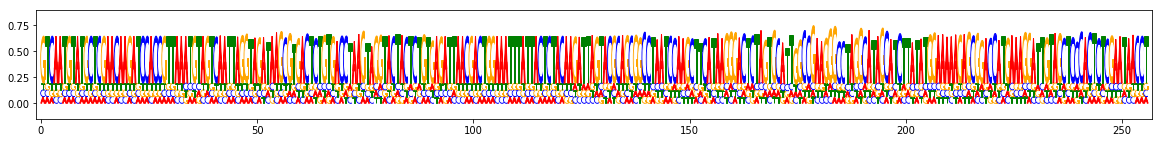

In [21]:
pwm, new_score = get_pwm([seq], get_score=True)
print('PWM score ' + str(new_score))
viz_sequence.plot_icweights(pwm[0])
ctcfgen.get_importance(seq, model, viz=1)
_ = viz_sequence.plot_icweights(seq)

In [22]:
# dream the sequences
seq = orig_seq
seq = limited_dream(seq, iterate, get_pwm, neg=True, verb=0, n=15)

#change = seq - orig_seq 
#viz_sequence.plot_weights(change)

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:56: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


PWM score 29.4496854805


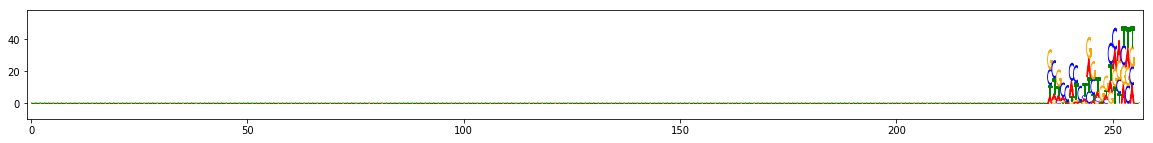

Prediction 0.0108025
Masked average prediciton difference


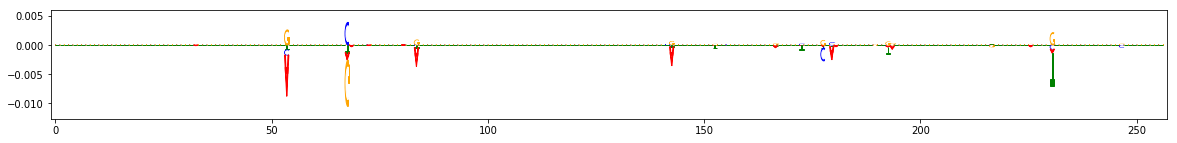

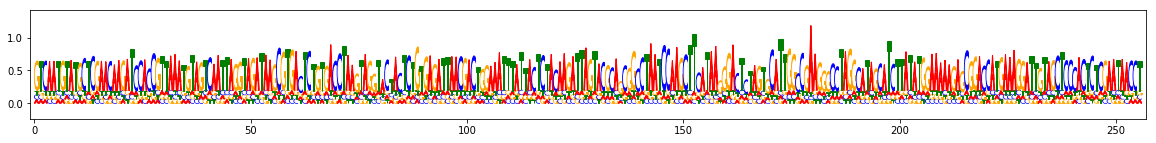

In [23]:
pwm, new_score = get_pwm([seq], get_score=True)
print('PWM score ' + str(new_score))
viz_sequence.plot_icweights(pwm[0])
ctcfgen.get_importance(seq, model, viz=1)
_ = viz_sequence.plot_icweights(seq)

In [24]:
seq_library = []
layer_name = 'final_output'
    
#find high scoring sequences
r = rand_seq_gen()
g = good_pred_gen(r)


for i in range(10):
    # get the specific filter within this layer we are looking at
    print('Layer: ' + layer_name)
    
    #build the iteration model
    iterate = build_iterate(model, 0, layer_name)
    seq = next(g)
    seq = seq*.6 + .1
    #viz_sequence.plot_icweights(seq, colors=colors)
    # dream the sequences
    score = model.predict(np.asarray([seq]*32))[0][0]
    print('Inital Prediction ' + str(score))
    get_pwm([seq], get_score=True)
    
    seq = limited_dream(seq, iterate, get_pwm, neg=True, verb=1, seq_center=1, n=20)
    
    seq_library.append(seq)
    score = model.predict(np.asarray([seq]*32))[0][0]
    print('Final Prediction ' + str(score))
    get_pwm([seq], get_score=True)
    viz_sequence.plot_icweights(seq)

plot_activations(model, np.asarray([seq_library[0]]*32), layer_name, get_max=True, all=False)

TypeError: good_pred_gen() missing 1 required positional argument: 'model'

In [ ]:
viz_sequence.plot_icweights(seq_library[2][130:210])

In [ ]:
seq_library = []
layer_name = 'conv1d_3'
    
#find high scoring sequences
r = rand_seq_gen()
g = good_pred_gen(r)


for i in range(1):
    # get the specific filter within this layer we are looking at
    print('Layer: ' + layer_name + ' Filter: ' +str(i))
    
    #build the iteration model
    iterate = build_iterate(model, 0, layer_name)
    seq = next(g)
    seq = seq*.6 + .1
    #viz_sequence.plot_icweights(seq, colors=colors)
    # dream the sequences
    seq = dream(seq, iterate, verb=1, seq_center=1, n=4)
    seq_library.append(seq)
    viz_sequence.plot_icweights(seq, colors=colors)

plot_activations(model, np.asarray([seq_library[0]]*32), layer_name, get_max=True, all=False)

In [ ]:
p = gen.pos_training_gen()
seq = ctcfgen.encode(next(p))
plot_activations(model, np.asarray([seq]*32), 'conv1d_1', all=False)
plot_activations(model, np.asarray([seq]*32), 'conv1d_2', all=False)
plot_activations(model, np.asarray([seq]*32), 'conv1d_3', all=False)
plot_activations(model, np.asarray([seq]*32), 'conv1d_4', all=False)
plot_activations(model, np.asarray([seq]*32), 'final_conv', all=False)

In [ ]:
def mutagenisis(seq):
    # do a mutant scan
    mutant_window=1

    # get a mutant batch generator
    mutant_gen = ctcfgen.ngram_mutant_gen(seq, n=mutant_window)
    g = ctcfgen.filled_batch(mutant_gen, batch_size=batch_size)
    
    # base importances as large-step gradients
    # score with base there - average of scores without base there
    mutant_preds = list()
    for batch in g:
        mutant_preds.append(model.predict_on_batch(batch))

    return np.asarray(mutant_preds).reshape((-1, 4))  

In [ ]:
def get_importance(seq):
    score = model.predict(np.asarray([seq]*32))[0][0]
    print('Score: ' + str(score))

    mutant_preds = mutagenisis(seq)
      
    logit_preds = np.asarray(logit(mutant_preds))
    logit_max = logit(score)
    if logit_max == np.inf:
        logit_max = np.nanmax(logit_preds[np.where(np.isfinite(logit_preds))])
        
    diffs = logit_preds - logit_max
    seq_center = 45 + np.argmax(np.max(abs(diffs[45:diffs.shape[0]-45]), axis=1), axis=0)
    print(seq_center)
    print('Sequence')
    viz_sequence.plot_icweights(seq, colors=colors)
    
    all_diffs = list()
    for base_seq, base_preds in zip(seq, logit_preds):
        this_base = list()
        for idx in range(4):
            this_base.append(base_preds[idx] - np.average(base_preds))
        all_diffs.append(list(this_base))

    all_diffs=np.asarray(all_diffs)

    score_diff = list()
    for base_seq, base_preds in zip(seq, logit_preds):
        idx = np.where(base_seq)
        score_diff.append(base_preds[idx] - np.average(base_preds))
      
    score_diff = (seq * score_diff)
    print('Masked average prediciton difference')
    viz_sequence.plot_weights(score_diff, colors=colors)

    print('Masked softmax average prediciton difference')
    viz_sequence.plot_icweights(np.multiply(seq, softmax([all_diffs])[0]), colors=colors)

    print('Softmax average prediction difference')
    viz_sequence.plot_icweights(softmax([all_diffs])[0], colors=colors)

In [ ]:
def write_fasta_distributition(out_path, input_seqs):
    with open(out_path, 'w') as out:
        for seq, identifier in zip(input_seqs, range(len(input_seqs))):
            for i in range(5):
                new_seq =seq_from_distribution(seq)
                string = ctcfgen.decode(new_seq).tostring().decode('UTF-8')
                print('>'+ str(identifier) + '-' + str(i) +'\n'+string+'\n')
                out.write('>'+ str(identifier) + '-' + str(i) +'\n'+string+'\n')

In [ ]:
seq_library = np.asarray(seq_library)
print(seq_library.shape)
for seq in seq_library:
    viz_sequence.plot_icweights(seq)

In [ ]:
i = 0
outfile = str(i)+'_'+layer_name+'.fa'
out_path = os.path.join(out_dir, outfile)
print(np.asarray(seq_library).shape)
write_fasta_distributition(out_path, np.asarray(seq_library))
viz_sequence.plot_weights(input_seqs[12])

In [ ]:
# what if we used differences as a measure of importance?
# 'good' bases will have the least change, 'bad' bases will have the largest positive change
pos_diffs = (input_seqs - orig_seqs).clip(min=0)
neg_diffs = (orig_seqs - input_seqs).clip(min=0)
overlay_seqs = softmax((input_seqs * orig_seqs)*4)
print('starting point:')
viz_sequence.plot_icweights(orig_seqs[4][78:178])
print('ideal sequence:')
viz_sequence.plot_icweights(input_seqs[4][78:178])
print('enriched in ideal:')
bad = viz_sequence.plot_icweights(pos_diffs[4][78:178])
print('enriched in original:')
viz_sequence.plot_icweights(neg_diffs[4][78:178])
print('found in both:')
good = viz_sequence.plot_icweights(overlay_seqs[4][78:178])
print('good-bad difference?')
viz_sequence.plot_weights(good-bad)

In [ ]:
x = np.asarray([0,4,5,6])
print(x)
print(np.square(x))
print(np.mean(np.square(x)))
x / (np.sqrt(np.mean(np.square(x))) + 1e-5)

In [ ]:
#build the iteration model
iterate = build_iterate(model, filter_index, layer_name)
    
#find high scoring sequences
g = good_batch_gen(rand_batch_gen, iterate)
input_seqs = next(g)
activations, grads = iterate([input_seqs, 0])
max_grad = np.amax(grads, axis=(2, 1))
step = 5/(max_grad)
step = np.asarray([np.full((input_window, 4), elem) for elem in step])

viz_sequence.plot_weights(input_seqs[0])
simple_step = input_seqs+ grads*step
viz_sequence.plot_weights(simple_step[0])

In [ ]:
viz_sequence.plot_weights(softmax(simple_step)[0])

In [ ]:
viz_sequence.plot_weights(np.log(softmax(simple_step))[0])